# Automatically  detect background pixels and construct a background for each source pixel

In this notebook, we will demonstrate how we can automaticallyt detect background pixels and create a background for masked pixels. To do this, we apply the following steps:
1) Use a segmentation algorithm to find the background pixels
2) Use PCA to construct a subspace representing the background component
    - This includes the sky lines
3) Project each background pixel into a truncated PCA space
4) Interpolate masked pixels into PCA space
    - This can be done by either standard interpolation or using an artificial neural network

In [1]:
import os
import sys
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import scipy.interpolate as spi
from sklearn import decomposition
from astropy.convolution import convolve
from photutils.segmentation import detect_sources
from photutils.segmentation import make_2dgaussian_kernel
from photutils.background import Background2D, MedianBackground

In [3]:
# Define user-specific variables
n_components = 10  # Number of PCA components to keep
outputDir = '/home/carterrhea/Documents'  # Output directory for plots and data
Luci_path = '/home/carterrhea/Documents/LUCI/'
#cube_dir = '/mnt/carterrhea/carterrhea/Perseus/SITELLE'  # Path to data cube
#cube_name = 'A0426_SN3.merged.cm1.1.0'  # don't add .hdf5 extension
cube_dir = '/mnt/carterrhea/carterrhea/NGC4449/'
cube_name = 'NGC4449_SN3'
object_name = 'NGC1275'
redshift = 0.0179  # Redshift
resolution = 1800

x_min = 200
x_max = 800
y_min = 1000
y_max = 1500

path = os.path.abspath(Luci_path)
sys.path.insert(0, path)  # add LUCI to the available paths
plt.style.use(os.path.join(Luci_path, 'light.mplstyle'))
from LuciBase import Luci

## Define background pixel search algorithm
We use a segmentation detection algorithm which is part of the [photutils](https://photutils.readthedocs.io/en/stable/) library. We also do some smoothing and set a threshold. By lowering the threshold, we increase the pixels that are in the background - this is a parameter that can be tweaked for your given object.

In [4]:
def find_background_pixels(deep_image, sigma_threshold=0.1, plot_mask=True):
    """
    This algorithm uses a sigma thresholding algorithm on the deep image to determine which pixels belong to the background.

    Args:
        deep_image: Deep image in 2D
        sigma_threshold: Threshold parameter for determining the background (default 0.1)
        plot_mask: Boolean to make/save background plot (default True)

    Return:
        idx: List of background pixel positions (list of tuples)
    """
    bkg_estimator = MedianBackground()
    bkg = Background2D(deep_image, (50, 50), filter_size=(3, 3),
                       bkg_estimator=bkg_estimator)  # Experimentally found this values to be good  
    deep_image -= bkg.background  # subtract the background
    threshold = sigma_threshold * bkg.background_rms
    kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0 - again experimentally found this to be a good parameter value
    convolved_data = convolve(deep_image, kernel)  # Convolve data
    segment_map = detect_sources(convolved_data, threshold, npixels=8)  # Apply detection
    idx_bkg = np.argwhere(np.abs(segment_map) < 1)  # Get only background pixels
    idx_source = np.argwhere(np.abs(segment_map) > 0)  # Get source pixels
    if plot_mask:
        plt.imshow(segment_map, origin='lower', cmap=segment_map.cmap, interpolation='nearest')
        plt.ylim(0, 2048)
        plt.xlim(0, 2048)
        plt.xlabel('RA (physical coordinates)')
        plt.ylabel('DEC (physical coordiantes)')
        plt.show()
        plt.savefig(os.path.join(outputDir, 'BackgroundPixelMap.png'))
    return idx_bkg, idx_source

# Read in SITELLE cube with LUCI
We now need to read in the SITELLE cube with LUCI so that we have access to the spectra

In [5]:
cube = Luci(Luci_path, cube_dir+'/'+cube_name, cube_dir, object_name, redshift, resolution, mdn=False)
deep = fits.open('/mnt/carterrhea/carterrhea/Perseus/SITELLE/Luci_outputs/NGC1275_lowres_deep.fits')[0].data
#deep = fits.open('/mnt/carterrhea/carterrhea/NGC4449/Luci_outputs/NGC4449_deep.fits')[0].data

Reading in data...


100%|█████████████████████████████████████████████| 9/9 [00:32<00:00,  3.63s/it]
2023-05-02 13:46:30.052951: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-02 13:46:30.052972: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-02 13:46:30.053007: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2023-05-02 13:46:30.053211: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Obtain background spectra
Since we already have our script to calculate the background pixels, we just need to call it and then extract the corresponding spectra from the SITELLE datacube.

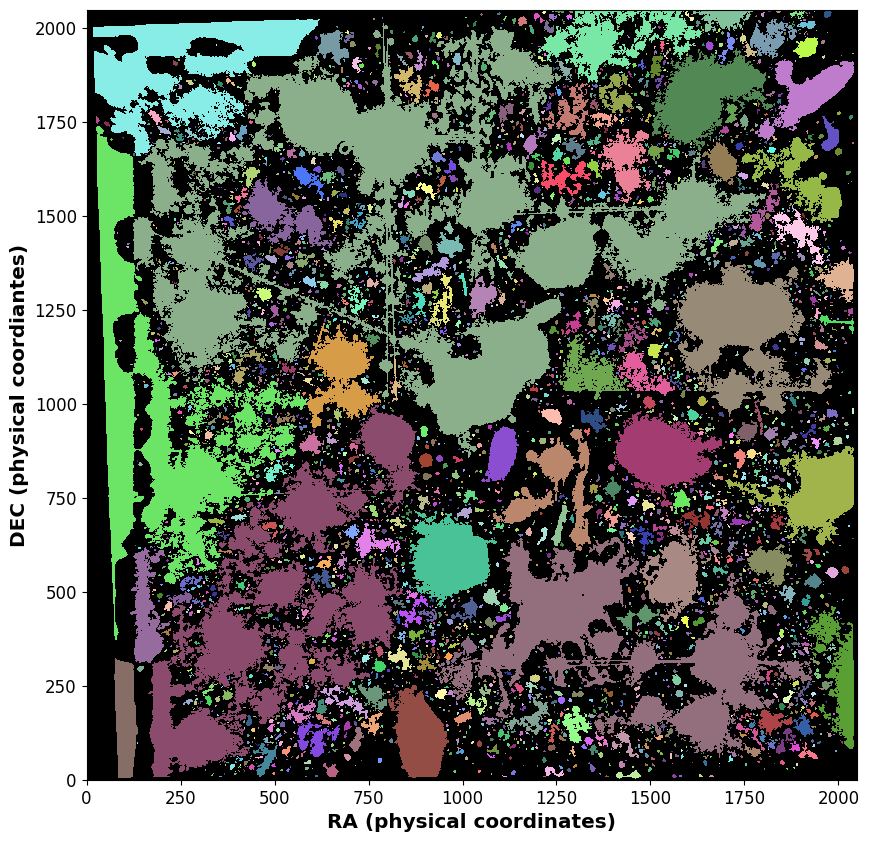

There are 150913 background pixels


<Figure size 1600x1000 with 0 Axes>

In [6]:
idx_bkg, idx_source = find_background_pixels(deep)  # List of background pixels
bkg_spectra = [cube.cube_final[index[0], index[1]] for index in idx_bkg if x_min<index[0]<x_max and y_min<index[1]<y_max]  # Get background pixels
print("There are %i background pixels"%(len(bkg_spectra)))

## Apply PCA Analysis and truncate the PCA space
We use the incremental PCA algorithm -- this makes a minor minor minor difference, but it is in general a more robust algorithm

In [20]:
pca = decomposition.IncrementalPCA(n_components=n_components)  # Call pca
pca.fit(bkg_spectra)  # Fit using background spectra
BkgTransformedPCA = pca.transform(bkg_spectra)  # Apply on background spectra

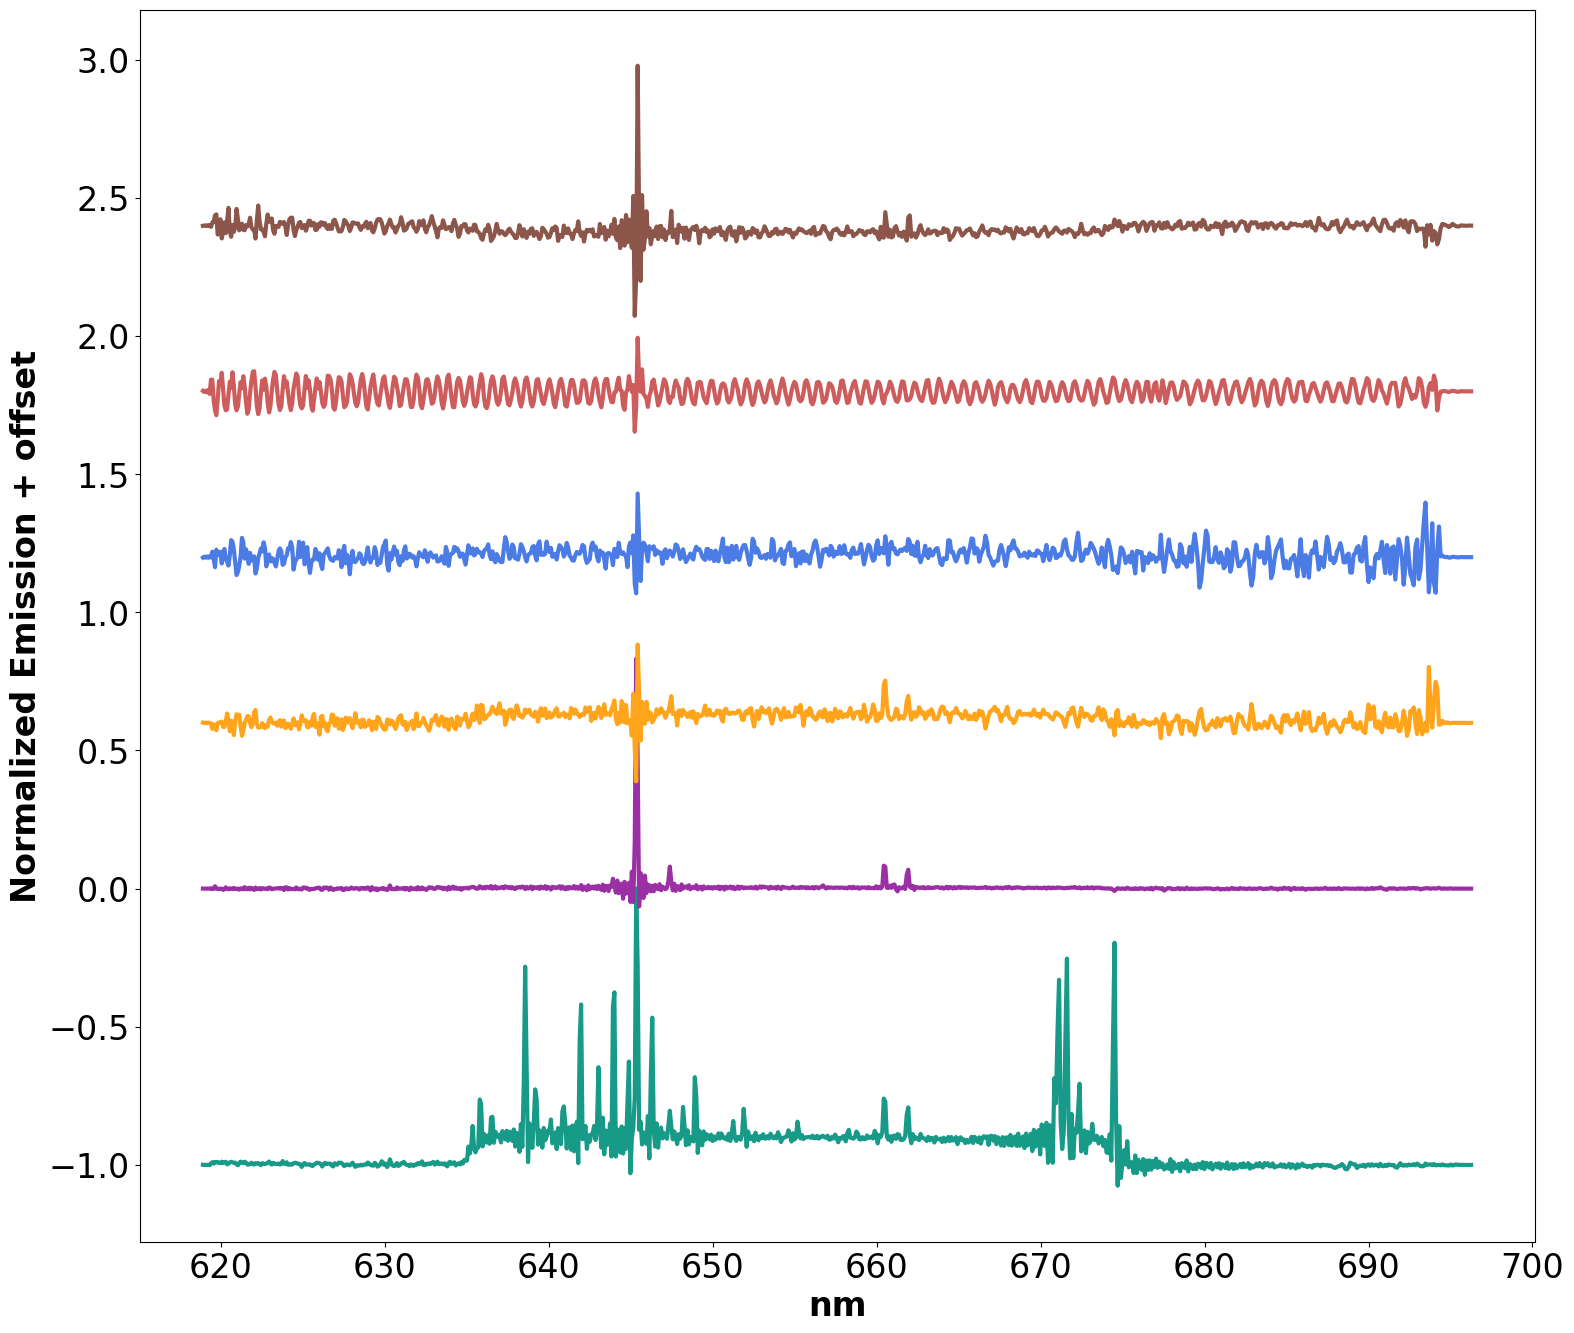

In [21]:
# Plot the primary components
plt.figure(figsize=(18, 16))
# plot the mean first
l = plt.plot(1e7/cube.spectrum_axis, pca.mean_/np.max(pca.mean_)-1,linewidth=3)
c = l[0].get_color()
#plt.text(12, -0.9, 'mean emission', color=c,fontsize='xx-large')
shift = 0.6
for i in range(5):  # Plot first 5 components
    l = plt.plot(1e7/cube.spectrum_axis, pca.components_[i] + (i*shift), linewidth=3)
    c = l[0].get_color()
    #plt.text(6, i*shift+0.1, "component %i" % (i + 1), color=c, fontsize='xx-large')
plt.xlabel('nm', fontsize=24)
plt.ylabel('Normalized Emission + offset',  fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(os.path.join(outputDir, 'PCA_components.png'))

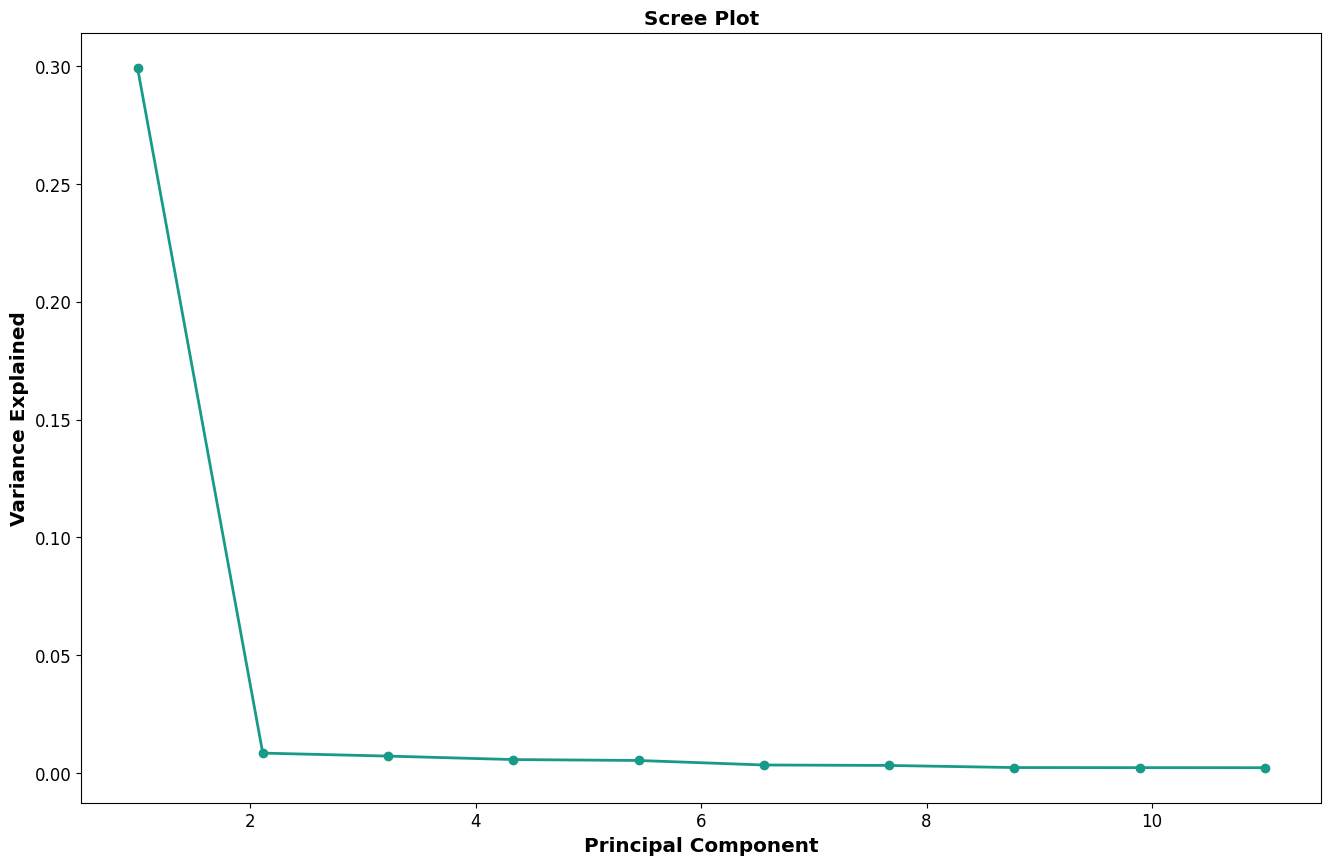

In [22]:
# Make scree plot
#PC_values = np.arange(pca.n_components_)[:n_components] + 1
plt.plot(np.linspace(1, n_components+1, n_components), pca.explained_variance_ratio_[:n_components], 'o-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.savefig(os.path.join(outputDir, 'PCA_scree.png'))

## Interpolate in truncated PCA space the missing (i.e. source) pixels
Here, we will obtain values for the source pixels (i.e. the pixels that were masked). This can be done using artificial neural networks or standard interpolation.
This will provide us will a background spectrum for each pixel, masked or otherwise, using the PCA subspace.

In [30]:
interpolatedSourcePixels = spi.griddata(
                                        [[index[0],index[1]] for index in idx_bkg if x_min<index[0]<x_max and y_min<index[1]<y_max],
                                        BkgTransformedPCA,
                                        [[index[0],index[1]] for index in idx_source if x_min<index[0]<x_max and y_min<index[1]<y_max],
                                        method='linear',
                                        )

In [31]:
bkg_pixels = [[index[0],index[1]] for index in idx_bkg if x_min<index[0]<x_max and y_min<index[1]<y_max]
src_pixels = [[index[0],index[1]] for index in idx_source if x_min<index[0]<x_max and y_min<index[1]<y_max]

In [32]:
bkg_x = [bkg[0] for bkg in bkg_pixels]
bkg_y = [bkg[1] for bkg in bkg_pixels]

src_x = [bkg[0] for bkg in src_pixels]
src_y = [bkg[1] for bkg in src_pixels]

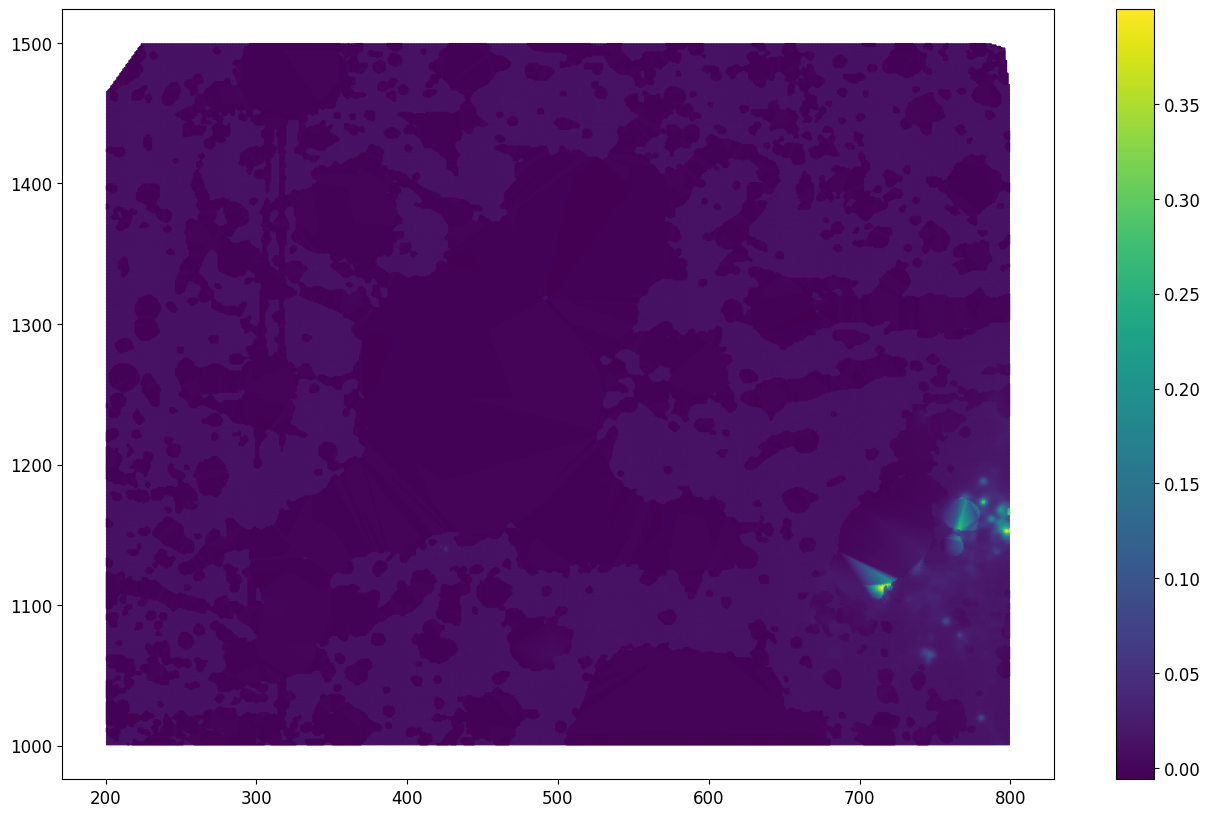

In [33]:
plt.scatter(bkg_x, bkg_y, c=BkgTransformedPCA[:,0]/np.max(BkgTransformedPCA[:,0]), s=0.5)
plt.scatter(src_x, src_y, c=interpolatedSourcePixels[:,0]/np.max(BkgTransformedPCA[:,0]), s=1)
plt.colorbar()